## Pre-Processing

Starting a Spark session

In [1]:
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from time import time
appName = "Big Data Analytics"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

C:\Users\aayus\spark-3.4.1-bin-hadoop3-scala2.13\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
mqtt = StructType([StructField('tcp_flags', StringType(), True), 
                   StructField('tcp_time_delta', DoubleType(), True), 
                   StructField('tcp_len', IntegerType(), True), 
                   StructField('mqtt_conack_flags', StringType(), True), 
                   StructField('mqtt_conack_flags_reserved', DoubleType(), True), 
                   StructField('mqtt_conack_flags_sp', DoubleType(), True), 
                   StructField('mqtt_conack_val', DoubleType(), True), 
                   StructField('mqtt_conflag_cleansess', DoubleType(), True), 
                   StructField('mqtt_conflag_passwd', DoubleType(), True), 
                   StructField('mqtt_conflag_qos', DoubleType(), True), 
                   StructField('mqtt_conflag_reserved', DoubleType(), True), 
                   StructField('mqtt_conflag_retain', DoubleType(), True), 
                   StructField('mqtt_conflag_uname', DoubleType(), True), 
                   StructField('mqtt_conflag_willflag', DoubleType(), True), 
                   StructField('mqtt_conflags', StringType(), True), 
                   StructField('mqtt_dupflag', DoubleType(), True), 
                   StructField('mqtt_hdrflags', StringType(), True), 
                   StructField('mqtt_kalive', DoubleType(), True), 
                   StructField('mqtt_len', DoubleType(), True), 
                   StructField('mqtt_msg', StringType(), True), 
                   StructField('mqtt_msgid', DoubleType(), True), 
                   StructField('mqtt_msgtype', DoubleType(), True), 
                   StructField('mqtt_proto_len', DoubleType(), True), 
                   StructField('mqtt_protoname', StringType(), True), 
                   StructField('mqtt_qos', DoubleType(), True), 
                   StructField('mqtt_retain', DoubleType(), True), 
                   StructField('mqtt_sub_qos', DoubleType(), True), 
                   StructField('mqtt_suback_qos', DoubleType(), True), 
                   StructField('mqtt_ver', DoubleType(), True), 
                   StructField('mqtt_willmsg', DoubleType(), True), 
                   StructField('mqtt_willmsg_len', DoubleType(), True), 
                   StructField('mqtt_willtopic', DoubleType(), True), 
                   StructField('mqtt_willtopic_len', DoubleType(), True), 
                   StructField('target', StringType(), True), 
                   StructField('train_flag', IntegerType(), False)])

In [6]:
df_train = spark.read.csv(r"D:\data\train70_reduced.csv", header = True, inferSchema= False, schema = mqtt)
df_test = spark.read.csv(r"D:\data\test30_reduced.csv", header = True, inferSchema= False, schema = mqtt)
df_train = df_train.withColumn('train_flag', lit(1)) #train flag is 1 if the data is training set or 0 if test set
df_test = df_test.withColumn('train_flag', lit(0))

In [7]:
df_comb = df_train.union(df_test)
df_comb.printSchema()
df_comb.show(vertical = True)

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: integer (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_flags_reserved: double (nullable = true)
 |-- mqtt_conack_flags_sp: double (nullable = true)
 |-- mqtt_conack_val: double (nullable = true)
 |-- mqtt_conflag_cleansess: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_qos: double (nullable = true)
 |-- mqtt_conflag_reserved: double (nullable = true)
 |-- mqtt_conflag_retain: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_conflag_willflag: double (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: double (nullable = true)
 |-

In [3]:
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="asdfghjkl@23456"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "mqtt.MQTT_Reduced"

In [ ]:
df_comb.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

Reading data in from the Postgres table we created earlier. 

In [4]:
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_read.show(1, vertical=True)

-RECORD 0--------------------------------
 tcp_flags                  | 0x00000010 
 tcp_time_delta             | 3.0E-6     
 tcp_len                    | 0          
 mqtt_conack_flags          | 0          
 mqtt_conack_flags_reserved | 0.0        
 mqtt_conack_flags_sp       | 0.0        
 mqtt_conack_val            | 0.0        
 mqtt_conflag_cleansess     | 0.0        
 mqtt_conflag_passwd        | 0.0        
 mqtt_conflag_qos           | 0.0        
 mqtt_conflag_reserved      | 0.0        
 mqtt_conflag_retain        | 0.0        
 mqtt_conflag_uname         | 0.0        
 mqtt_conflag_willflag      | 0.0        
 mqtt_conflags              | 0          
 mqtt_dupflag               | 0.0        
 mqtt_hdrflags              | 0          
 mqtt_kalive                | 0.0        
 mqtt_len                   | 0.0        
 mqtt_msg                   | 0          
 mqtt_msgid                 | 0.0        
 mqtt_msgtype               | 0.0        
 mqtt_proto_len             | 0.0 

Checking null counts of columns

In [5]:
null_counts_df = df_read.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in df_read.columns])

null_counts_df.show(truncate=False, vertical=True)

-RECORD 0-------------------------
 tcp_flags                  | 0   
 tcp_time_delta             | 0   
 tcp_len                    | 0   
 mqtt_conack_flags          | 0   
 mqtt_conack_flags_reserved | 0   
 mqtt_conack_flags_sp       | 0   
 mqtt_conack_val            | 0   
 mqtt_conflag_cleansess     | 0   
 mqtt_conflag_passwd        | 0   
 mqtt_conflag_qos           | 0   
 mqtt_conflag_reserved      | 0   
 mqtt_conflag_retain        | 0   
 mqtt_conflag_uname         | 0   
 mqtt_conflag_willflag      | 0   
 mqtt_conflags              | 0   
 mqtt_dupflag               | 0   
 mqtt_hdrflags              | 0   
 mqtt_kalive                | 0   
 mqtt_len                   | 0   
 mqtt_msg                   | 0   
 mqtt_msgid                 | 0   
 mqtt_msgtype               | 0   
 mqtt_proto_len             | 0   
 mqtt_protoname             | 0   
 mqtt_qos                   | 0   
 mqtt_retain                | 0   
 mqtt_sub_qos               | 0   
 mqtt_suback_qos    

No null values found, however I observed there were a lot of columns with just 0 in them. Let us find out which are those. 

In [6]:
zero_counts_df = df_read.select([(count(when(col(c) == 0, c))/count(col(c)) * 100).alias(c) \
                        for c in df_read.columns])

zero_counts_df.show(truncate=False, vertical=True)

-RECORD 0----------------------------------------
 tcp_flags                  | 0.0                
 tcp_time_delta             | 9.349541905383518  
 tcp_len                    | 37.288176565861676 
 mqtt_conack_flags          | 99.00826745956923  
 mqtt_conack_flags_reserved | 100.0              
 mqtt_conack_flags_sp       | 100.0              
 mqtt_conack_val            | 99.56849662774675  
 mqtt_conflag_cleansess     | 99.00826745956923  
 mqtt_conflag_passwd        | 99.57030966712597  
 mqtt_conflag_qos           | 100.0              
 mqtt_conflag_reserved      | 100.0              
 mqtt_conflag_retain        | 100.0              
 mqtt_conflag_uname         | 99.56910097420649  
 mqtt_conflag_willflag      | 100.0              
 mqtt_conflags              | 99.00826745956923  
 mqtt_dupflag               | 94.34724538883651  
 mqtt_hdrflags              | 37.599717165856845 
 mqtt_kalive                | 99.00826745956923  
 mqtt_len                   | 38.45909783160491  


We can see a lot of columns have more than 90% of values as 0. These will not be useful in our machine learning models, hence can be dropped. 

In [7]:
zero_pd = zero_counts_df.toPandas()
drop_columns = []
for column in zero_pd.columns:
    if zero_pd[column][0] > 90:
        drop_columns.append(column)
        
print(drop_columns)
df_drop = df_read

['mqtt_conack_flags', 'mqtt_conack_flags_reserved', 'mqtt_conack_flags_sp', 'mqtt_conack_val', 'mqtt_conflag_cleansess', 'mqtt_conflag_passwd', 'mqtt_conflag_qos', 'mqtt_conflag_reserved', 'mqtt_conflag_retain', 'mqtt_conflag_uname', 'mqtt_conflag_willflag', 'mqtt_conflags', 'mqtt_dupflag', 'mqtt_kalive', 'mqtt_proto_len', 'mqtt_protoname', 'mqtt_retain', 'mqtt_sub_qos', 'mqtt_suback_qos', 'mqtt_ver', 'mqtt_willmsg', 'mqtt_willmsg_len', 'mqtt_willtopic', 'mqtt_willtopic_len']


In [8]:
for column in drop_columns:
    df_drop = df_drop.drop(column)
    
df_drop.show(1, vertical = True)

-RECORD 0------------------------------
 tcp_flags      | 0x00000018           
 tcp_time_delta | 1.0E-6               
 tcp_len        | 74                   
 mqtt_hdrflags  | 0x00000032           
 mqtt_len       | 169.0                
 mqtt_msg       | 31656539393433464... 
 mqtt_msgid     | 8855.0               
 mqtt_msgtype   | 3.0                  
 mqtt_qos       | 1.0                  
 target         | dos                  
 train_flag     | 0                    
only showing top 1 row



In [9]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [11]:
df_with_outlier_handling = find_outliers(df_drop)
df_with_outlier_handling.show(1, vertical=True)

-RECORD 0--------------------
 tcp_flags      | 0x00000010 
 tcp_time_delta | 1.8E-5     
 tcp_len        | 0          
 mqtt_hdrflags  | 0          
 mqtt_len       | 0.0        
 mqtt_msg       | 0          
 mqtt_msgid     | 0.0        
 mqtt_msgtype   | 0.0        
 mqtt_qos       | 0.0        
 target         | legitimate 
 train_flag     | 0          
 total_outliers | 0          
only showing top 1 row



In [12]:
df_with_outlier_handling.groupby("total_outliers").count().show()

+--------------+------+
|total_outliers| count|
+--------------+------+
|             1| 61133|
|             0|269803|
+--------------+------+



No rows with significant number of outliers found

In [13]:
numeric_features = ['tcp_time_delta',
 'tcp_len',
 'mqtt_len',
 'mqtt_msgid',
 'mqtt_msgtype',
 'mqtt_qos',]

In [14]:
correlation_matrix = df_drop[numeric_features].toPandas().corr()
print(correlation_matrix)

                tcp_time_delta   tcp_len  mqtt_len  mqtt_msgid  mqtt_msgtype  \
tcp_time_delta        1.000000 -0.006839 -0.036893   -0.048444      0.282967   
tcp_len              -0.006839  1.000000  0.274388    0.167136      0.085966   
mqtt_len             -0.036893  0.274388  1.000000    0.595785      0.261949   
mqtt_msgid           -0.048444  0.167136  0.595785    1.000000      0.390695   
mqtt_msgtype          0.282967  0.085966  0.261949    0.390695      1.000000   
mqtt_qos             -0.038094  0.271450  0.988156    0.612174      0.228781   

                mqtt_qos  
tcp_time_delta -0.038094  
tcp_len         0.271450  
mqtt_len        0.988156  
mqtt_msgid      0.612174  
mqtt_msgtype    0.228781  
mqtt_qos        1.000000  


MQTT_LEN and MQTT_QOS have correlation of 0.988. Dropping MQTT_QOS. Also MQTT_MSQ is the actual content of the message which will be difficult to one hot encode or convert ot numerical values. This can be dropped too. 

In [15]:
df_drop = df_drop.drop('mqtt_qos')
df_drop = df_drop.drop('mqtt_msg')

Let's check number of classes in the categorcal variables

In [16]:
df_drop.groupBy('tcp_flags').count().show()

+----------+------+
| tcp_flags| count|
+----------+------+
|0x00000004|  1592|
|0x00000010|134547|
|0x00000019|   738|
|0x00000002|  3372|
|0x00000012|  3372|
|0x00000014|    41|
|0x00000018|183076|
|0x00000011|  4198|
+----------+------+



In [17]:
df_drop.groupBy('mqtt_hdrflags').count().show()

+-------------+------+
|mqtt_hdrflags| count|
+-------------+------+
|   0x00000031|   121|
|   0x00000090|    82|
|            0|124431|
|   0x000000d0|  1427|
|   0x00000010|  3282|
|   0x00000082|    82|
|   0x00000030|103457|
|   0x00000040| 38885|
|   0x000000e0|    18|
|   0x00000020|  3282|
|   0x0000003a| 18707|
|   0x00000032| 35724|
|   0x00000050|    39|
|   0x000000c0|  1399|
+-------------+------+



In [18]:
df_drop.groupBy('mqtt_msgtype').count().show()

+------------+------+
|mqtt_msgtype| count|
+------------+------+
|         8.0|    82|
|         0.0|124431|
|         1.0|  3282|
|         4.0| 38885|
|        14.0|    18|
|         3.0|158009|
|         2.0|  3282|
|        13.0|  1427|
|         5.0|    39|
|         9.0|    82|
|        12.0|  1399|
+------------+------+



In [19]:
df_drop.groupBy('mqtt_msgid').count().show()

+----------+-----+
|mqtt_msgid|count|
+----------+-----+
|    6765.0|   10|
|    9753.0|   10|
|    5776.0|   13|
|    3980.0|    9|
|    7554.0|   17|
|    6653.0|    9|
|    2815.0|   11|
|     692.0|    8|
|    6454.0|   15|
|     934.0|    7|
|    4142.0|    8|
|    1761.0|    5|
|    7115.0|    8|
|    3597.0|   15|
|    5983.0|   10|
|     305.0|   13|
|    7782.0|   11|
|    5858.0|   10|
|    8649.0|    7|
|    2734.0|    6|
+----------+-----+
only showing top 20 rows



In [20]:
df_drop.groupBy('target').count().show()

+----------+------+
|    target| count|
+----------+------+
|   slowite|  9202|
|bruteforce| 14501|
|     flood|   613|
| malformed| 10924|
|       dos|130233|
|legitimate|165463|
+----------+------+



TCP_FLAGS, MQTT_MSGTYPE and MQTT_HDRFLAGS have reasonable number of classes hence can be one hot encoded. MQTT_MSGID has a large number of classes hence I will use it as a continuous variable.

In [21]:
continuous_cols = ['tcp_time_delta', 'tcp_len', 'mqtt_len', 'mqtt_msgid',]

In [22]:
nominal_cols = ['mqtt_hdrflags', 'tcp_flags', 'mqtt_msgtype']

Creating train and test dataframes 

In [23]:
df_train = df_drop.select('*').where(df_drop.train_flag == 1)
df_test = df_drop.select('*').where(df_drop.train_flag == 0)
df_train = df_train.drop('train_flag')
df_test = df_test.drop('train_flag')

In [24]:
#pipeline for pre-processing

def class_to_label(name):
        if name == 'legitimate':
            return 0
        elif name == 'dos':
            return 1
        elif name == 'bruteforce':
            return 2
        elif name == 'malformed':
            return 3
        elif name == 'slowite':
            return 4
        elif name == 'flood':
            return 5

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_binary = udf(lambda name: class_to_label(name))
        output_df = dataset.withColumn('outcome', label_to_binary(col('target'))).drop("target")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))
        return output_df

class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df
    
def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+nominal_onehot_cols
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
         stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    
    return pipeline 

In [25]:
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(df_train) #fitting the pipeline

In [26]:
df_train_vec = preprocess_pipeline_model.transform(df_train)
df_test_vec = preprocess_pipeline_model.transform(df_test)

In [27]:
df_train_vec.printSchema()
df_train_vec.show(vertical = True)

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)

-RECORD 0------------------------
 features | (34,[0,1,2,5,17,2... 
 outcome  | 0.0                  
-RECORD 1------------------------
 features | (34,[0,1,2,3,7,18... 
 outcome  | 1.0                  
-RECORD 2------------------------
 features | (34,[0,1,2,3,7,18... 
 outcome  | 1.0                  
-RECORD 3------------------------
 features | (34,[0,1,2,5,17,2... 
 outcome  | 0.0                  
-RECORD 4------------------------
 features | (34,[0,1,2,3,6,17... 
 outcome  | 1.0                  
-RECORD 5------------------------
 features | (34,[0,4,18,25],[... 
 outcome  | 0.0                  
-RECORD 6------------------------
 features | (34,[0,4,18,25],[... 
 outcome  | 0.0                  
-RECORD 7------------------------
 features | (34,[0,1,2,5,17,2... 
 outcome  | 0.0                  
-RECORD 8------------------------
 features | (34,[0,1,2,5,17,2... 
 outcome  | 0.0                

## Machine Learning

### Spark Models

Since this is a multiclass classification problem, I used multinomial Logistic regression and random forest classifier in Spark. I wanted to compare a probabilistic model with a decision tree model. 

In [32]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier

lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'outcome')

In [33]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', 
    labelCol='outcome', metricName='accuracy')

lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0])
             .build())

rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5])
             .build())

lr_cv_base = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, evaluator=evaluator, numFolds=5)
rf_cv_base = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, evaluator=evaluator, numFolds=5)

In [53]:
lrModel = lr_cv_base.fit(df_train_vec)
rfModel = rf_cv_base.fit(df_train_vec)

In [54]:
predictions_lr_train = lrModel.transform(df_train_vec)
predictions_lr = lrModel.transform(df_test_vec)

In [55]:
accuracy_train_lr = (predictions_lr_train.filter(predictions_lr_train.outcome == predictions_lr_train.prediction)
    .count() / float(predictions_lr_train.count()))

accuracy_test_lr = (predictions_lr.filter(predictions_lr.outcome == predictions_lr.prediction)
    .count() / float(predictions_lr.count()))
print(f"Train Accuracy for Logistic Regression : {np.round(accuracy_train_lr*100,2)}%")
print(f"Test Accuracy for Logistic Regression: {np.round(accuracy_test_lr*100,2)}%")

Train Accuracy for Logistic Regression : 82.15%
Test Accuracy for Logistic Regression: 82.04%


In [56]:
predictions_rf_train = rfModel.transform(df_train_vec)
predictions_rf = rfModel.transform(df_test_vec)
accuracy_train_rf = (predictions_rf_train.filter(predictions_rf_train.outcome == predictions_rf_train.prediction)
    .count() / float(predictions_rf_train.count()))

accuracy_test_rf = (predictions_rf.filter(predictions_rf.outcome == predictions_rf.prediction)
    .count() / float(predictions_rf.count()))
print(f"Train Accuracy for Random Forest: {np.round(accuracy_train_rf*100,2)}%")
print(f"Test Accuracy for Random Forest: {np.round(accuracy_test_rf*100,2)}%")

Train Accuracy for Random Forest: 82.08%
Test Accuracy for Random Forest: 82.08%


Confusion matrix, without normalization
[[49637     0     0     0     2     0]
 [11173 27866    29     9     0     0]
 [ 1707     0  2629    15     0     0]
 [ 1092    12  1308   866     0     0]
 [ 1316     0  1033     8   404     0]
 [    0     0     0     0     0     0]]


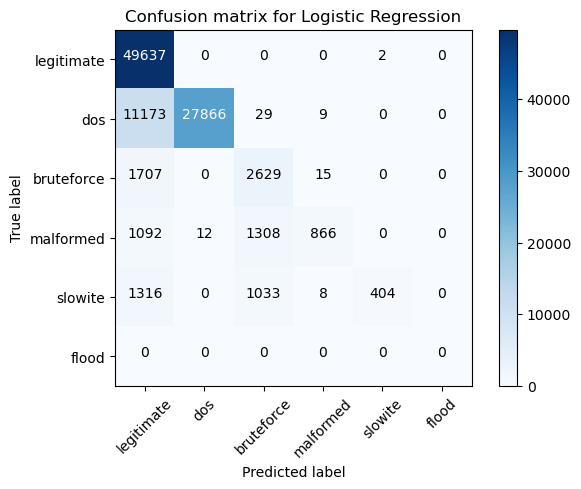

In [36]:
from sklearn.metrics import confusion_matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=[0.0,1.0,2.0,3.0,4.0, 5.0]
class_names_str=["legitimate","dos",'bruteforce','malformed','slowite', 'flood']

outcome_true = predictions_lr.select("outcome")
outcome_true = outcome_true.toPandas()

pred = predictions_lr.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix for Logistic Regression')
plt.show()

Confusion matrix, without normalization
[[49437   202     0     0     0     0]
 [ 9369 29679    29     0     0     0]
 [ 1907   195  2210    39     0     0]
 [ 1554   203   821   700     0     0]
 [ 1446    57   451    24   783     0]
 [    0     0     0     0     0     0]]


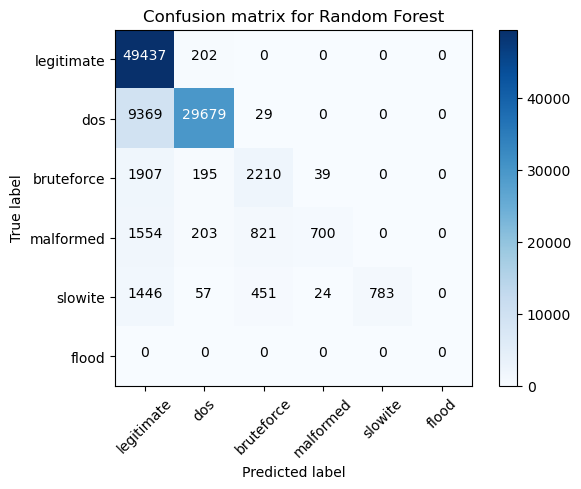

In [37]:
outcome_true = predictions_rf.select("outcome")
outcome_true = outcome_true.toPandas()

pred = predictions_rf.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix for Random Forest')
plt.show()

### Hyperparameter tuning for the two Spark models

Chosen hyperparamters for Logistic Regression: Regularization, Maximum iterations and Thresholds

Chosen hyperparamters for Random Forest: Maximum depth and Max bins

In [46]:
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 1, 2.0])
             .addGrid(lr.maxIter, [100, 500])
             .addGrid(lr.thresholds, [[1.5, 0.9, 1, 1, 1, 1], [1,1,1,1,1,1]])   
             .build())

rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 20, 30])
             .addGrid(rf.maxBins, [32, 64])
             .build())

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', 
    labelCol='outcome', metricName='accuracy')

lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, 
                    evaluator=evaluator, numFolds=5)

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, 
                    evaluator=evaluator, numFolds=5)

In [47]:
lr_cv_model = lr_cv.fit(df_train_vec)
rf_cv_model = rf_cv.fit(df_train_vec)
lr_cv_prediction_test = lr_cv_model.transform(df_test_vec)
rf_cv_prediction_test = rf_cv_model.transform(df_test_vec)

In [48]:
accuracy_lr_cv = (lr_cv_prediction_test.filter(lr_cv_prediction_test.outcome == lr_cv_prediction_test.prediction)
    .count() / float(lr_cv_prediction_test.count()))

accuracy_rf_cv = (rf_cv_prediction_test.filter(rf_cv_prediction_test.outcome == rf_cv_prediction_test.prediction)
    .count() / float(rf_cv_prediction_test.count()))
print('Accuracy on the Test set:')
print('Accuracy for Logistic Regression after Cross-Validation:' + str(np.round(accuracy_lr_cv*100,2)))
print('Accuracy for Random Forest after Cross-Validation:' + str(np.round(accuracy_rf_cv*100,2)))

Accuracy on the Test set:
Accuracy for Logistic Regression after Cross-Validation:81.59
Accuracy for Random Forest after Cross-Validation:89.67


Test accuracy for Random Forests went up from 82.08% to 89.67% whereas logistic regression did not improve

### PyTorch Models

In [34]:
df_train_pd = df_train_vec.toPandas()
df_test_pd = df_test_vec.toPandas()

In [35]:
x_train = torch.from_numpy(np.array(df_train_pd['features'].values.tolist(), np.float32))
y_train = torch.from_numpy(np.array(df_train_pd['outcome'].values.tolist(), np.int64))
x_val = torch.from_numpy(np.array(df_test_pd['features'].values.tolist(), np.float32))
y_val = torch.from_numpy(np.array(df_test_pd['outcome'].values.tolist(), np.int64))

In [36]:
class myDataset(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
train_dataset = myDataset(x_train, y_train)
val_dataset = myDataset(x_val, y_val)

In [37]:
def loader(batch_size = 64):
    batch_size = batch_size
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
    return train_loader, val_loader

I created two neural networks, one with 1 hidden layer and other with 3 hidden layers to compare the effect of depth

### Model 1

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(34, 16),
            nn.ReLU(),
            nn.Linear(16, 6),
            )
    def forward(self, x):
        y = self.sequential(x)
        return y
    
model = Net()
print(model)

Net(
  (sequential): Sequential(
    (0): Linear(in_features=34, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=6, bias=True)
  )
)


In [40]:
# creating some functions for plotting

def plot_loss(train_loss, val_loss):
    plt.plot(train_loss,label="Training")
    plt.plot(val_loss,label="Validation",linewidth=1)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title('Loss vs Epoch')
    plt.show()
    
    
def plot_accuracies(train_accuracies, val_accuracies):
    plt.plot(train_accuracies,label="Training")
    plt.plot(val_accuracies,label="Validation",linewidth=1)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title('Accuracy vs Epoch')
    plt.show()
    
# the training function

def train(model, train_loader, val_loader, lr = 0.01, epochs = 1000, gamma = 1, create_plot = True, use_GPU = False, verbose = True):
    # YOUR CODE GOES HERE
    
    if use_GPU:
        device = torch.device('cuda:0')
        if verbose: print('Using GPU ' + str(torch.cuda.get_device_properties(0).name) +'...')
        
    else:
        device = torch.device('cpu')
        if verbose: print('Using CPU...')
        
    model = model.to(device = device)
        
        
        
    
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)
    
    train_losses = []
    val_losses = []
    train_losses_iter = []
    val_losses_iter = []
    train_accuracies = []
    val_accuracies = []
    current_best_accuracy = 0
    
    for epoch in range(epochs):
        start_time = time()
        batch_loss = []
        batch_accuracy = []
        model.train()
        
        for x_batch, y_batch in train_loader:
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            preds_score = model(x_batch)
            loss_train = lossfun(preds_score, y_batch)
            train_losses_iter.append(loss_train.item())
    
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            batch_loss.append(loss_train.item())
            
            preds_label = torch.argmax(preds_score.detach(), dim = 1)
            batch_accuracy.append(torch.sum(preds_label == y_batch).item()/x_batch.shape[0])

            
            
        
        model.eval()
        val_batch_loss = []
        val_batch_accuracy = []
        
        for x_batch, y_batch in val_loader:
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
                
            preds_val_score = model(x_batch)
            loss_val = lossfun(preds_val_score, y_batch)
            val_losses_iter.append(loss_val.item())
            val_batch_loss.append(loss_val.item())
            
            preds_val_label = torch.argmax(preds_val_score.detach(), dim = 1)
            val_batch_accuracy.append(torch.sum(preds_val_label == y_batch).item()/x_batch.shape[0])
            
            
        train_losses.append(np.mean(np.array(batch_loss)))
        train_accuracies.append(np.mean(np.array(batch_accuracy)))
        val_losses.append(np.mean(np.array(val_batch_loss)))
        val_accuracies.append(np.mean(np.array(val_batch_accuracy)))
        
        scheduler.step()
        
        end_time = time()
        if verbose: print(f"Epoch {epoch + 1} of {epochs}: Train Loss = {train_losses[-1]} Validation Loss = {val_losses[-1]}")
        if verbose: print(f"Train Accuracy = {np.round(train_accuracies[-1] * 100, 2)} Validation Accuracy ={np.round(val_accuracies[-1] * 100, 2)}")
        if use_GPU:
            if verbose: print('Time taken on GPU: ' + str(end_time - start_time))
        else:
            if verbose: print('Time taken on CPU: ' + str(end_time - start_time))
            
        
        if val_accuracies[-1] > current_best_accuracy:
            if verbose: print('Current epoch is best so far, Saving model...')
            torch.save(model.state_dict(), 'current best model')
            current_best_accuracy = val_accuracies[-1]
        
    
    if create_plot:
        plot_loss(train_losses, val_losses)
        plot_accuracies(train_accuracies, val_accuracies)

    return current_best_accuracy

In [22]:
train_loader, val_loader = loader()

Using GPU NVIDIA GeForce GTX 1050...
Epoch 1 of 20: Train Loss = 0.4735890615422752 Validation Loss = 0.44220331481168257
Train Accuracy = 81.46 Validation Accuracy =82.0
Time taken on GPU: 19.884042024612427
Current epoch is best so far, Saving model...
Epoch 2 of 20: Train Loss = 0.42927701875402785 Validation Loss = 0.440206207651837
Train Accuracy = 82.07 Validation Accuracy =82.04
Time taken on GPU: 14.84002423286438
Current epoch is best so far, Saving model...
Epoch 3 of 20: Train Loss = 0.42689766502676746 Validation Loss = 0.4389256174992962
Train Accuracy = 82.1 Validation Accuracy =81.73
Time taken on GPU: 14.487602710723877
Epoch 4 of 20: Train Loss = 0.4251679632421686 Validation Loss = 0.4388485378249712
Train Accuracy = 82.16 Validation Accuracy =82.29
Time taken on GPU: 14.999281883239746
Current epoch is best so far, Saving model...
Epoch 5 of 20: Train Loss = 0.4233177815311851 Validation Loss = 0.43693940363555533
Train Accuracy = 82.33 Validation Accuracy =82.27
Tim

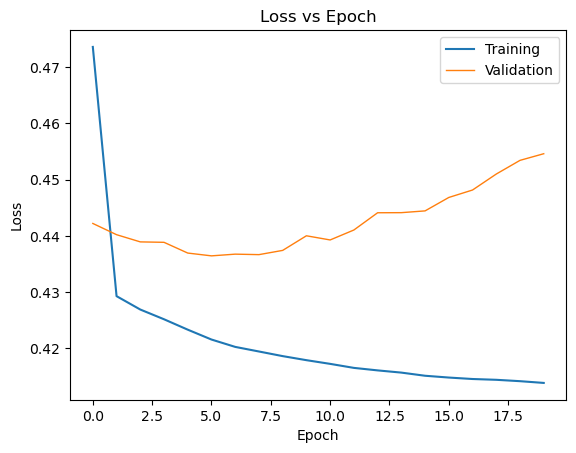

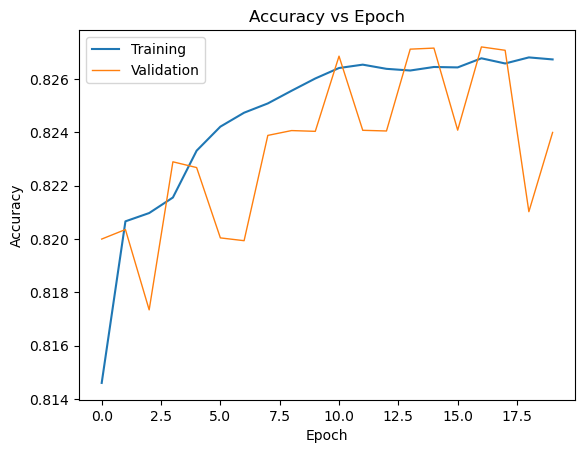

Final Accuracy: 82.72096178628074%


In [23]:
accuracy = train(model, train_loader, val_loader, lr = 0.001, epochs = 20, gamma = 1, use_GPU = True, create_plot = True, verbose = True)
print(f'Final Accuracy: {accuracy * 100}%')

### Hyperparamter tuning for Model 1

I trained the model over different learning rates and batch sizes and stored the accuracies

In [67]:
lr_params = [0.1, 0.01, 0.001]
batch_sizes = [32, 64, 128]
tuning_accs = {}
for lr in lr_params:
    for batch_size in batch_sizes:
        train_loader, val_loader = loader(batch_size=batch_size)
        model = Net()
        acc = train(model, train_loader, val_loader, lr = lr, epochs = 20, gamma = 0.995, create_plot = False, use_GPU = True, verbose = False)
        tuning_accs[str(lr) + ', ' + str(batch_size)] = acc
        print(f'Training completed for Learning Rate: {lr}, Batch Size: {batch_size}')

Training completed for Learning Rate: 0.1, Batch Size: 32
Training completed for Learning Rate: 0.1, Batch Size: 64
Training completed for Learning Rate: 0.1, Batch Size: 128
Training completed for Learning Rate: 0.01, Batch Size: 32
Training completed for Learning Rate: 0.01, Batch Size: 64
Training completed for Learning Rate: 0.01, Batch Size: 128
Training completed for Learning Rate: 0.001, Batch Size: 32
Training completed for Learning Rate: 0.001, Batch Size: 64
Training completed for Learning Rate: 0.001, Batch Size: 128


In [68]:
tuning_accs

{'0.1, 32': 0.8114410062222663,
 '0.1, 64': 0.8092860948651864,
 '0.1, 128': 0.8153225229095074,
 '0.01, 32': 0.8209355400480923,
 '0.01, 64': 0.8232181800158603,
 '0.01, 128': 0.8269475318585338,
 '0.001, 32': 0.8271593557103547,
 '0.001, 64': 0.8273753469468677,
 '0.001, 128': 0.8271397121993127}

We can see learning rate of 0.001 with batchsize of 64 has the highest accuracy of 82.73%

### Training model 1 on tuned hyperparamters and reporting accuracy on the test set

Using GPU NVIDIA GeForce GTX 1050...
Epoch 1 of 20: Train Loss = 0.4724561248777321 Validation Loss = 0.443633631390241
Train Accuracy = 81.14 Validation Accuracy =82.02
Time taken on GPU: 13.362596273422241
Current epoch is best so far, Saving model...
Epoch 2 of 20: Train Loss = 0.42899020771130675 Validation Loss = 0.43881255508275685
Train Accuracy = 82.09 Validation Accuracy =81.72
Time taken on GPU: 14.615417003631592
Epoch 3 of 20: Train Loss = 0.4267841368213872 Validation Loss = 0.4393321292801309
Train Accuracy = 82.09 Validation Accuracy =81.75
Time taken on GPU: 15.814131021499634
Epoch 4 of 20: Train Loss = 0.42514535742734677 Validation Loss = 0.43776672944119294
Train Accuracy = 82.14 Validation Accuracy =82.06
Time taken on GPU: 14.413451671600342
Current epoch is best so far, Saving model...
Epoch 5 of 20: Train Loss = 0.42381990274095405 Validation Loss = 0.43675239852716014
Train Accuracy = 82.27 Validation Accuracy =82.28
Time taken on GPU: 13.877720594406128
Curren

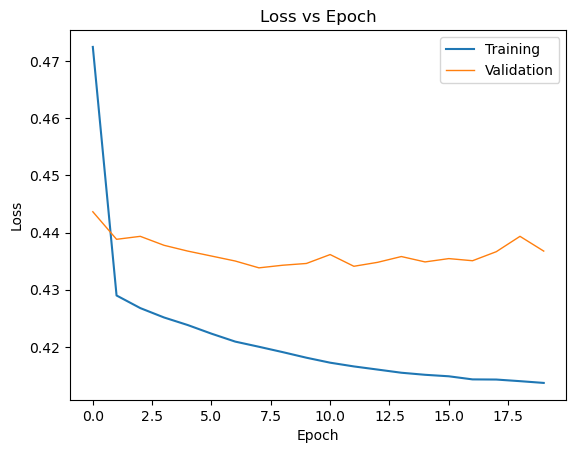

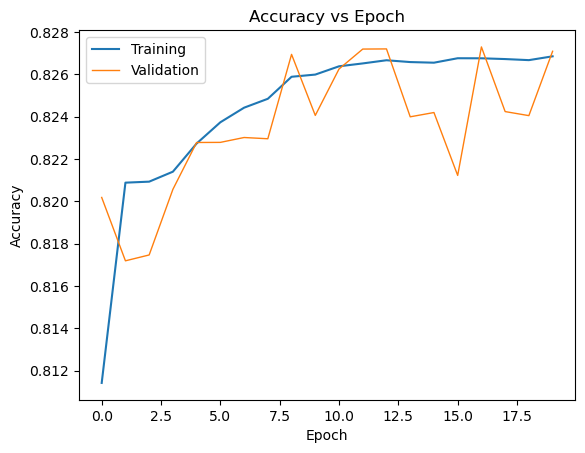

Accuracy on the Test set for tuned model 1: 82.7301001189532%


In [25]:
train_loader, val_loader = loader(batch_size = 64)
model_tuned = Net()
acc = train(model_tuned, train_loader, val_loader, lr = 0.001, epochs = 20, gamma = 0.995, create_plot = True, use_GPU = True, verbose = True)
print(f'Accuracy on the Test set for tuned model 1: {acc * 100}%')

### Model 2

In [38]:
class Net_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(34, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 6)
            )
    def forward(self, x):
        y = self.sequential(x)
        return y
    
model = Net_deep()
print(model)

Net_deep(
  (sequential): Sequential(
    (0): Linear(in_features=34, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=6, bias=True)
  )
)


Using GPU NVIDIA GeForce GTX 1050...
Epoch 1 of 20: Train Loss = 0.4751241327813976 Validation Loss = 0.4491448727311547
Train Accuracy = 80.96 Validation Accuracy =81.94
Time taken on GPU: 18.11886715888977
Current epoch is best so far, Saving model...
Epoch 2 of 20: Train Loss = 0.43248767274848665 Validation Loss = 0.44544707933805655
Train Accuracy = 82.02 Validation Accuracy =81.94
Time taken on GPU: 13.009419202804565
Current epoch is best so far, Saving model...
Epoch 3 of 20: Train Loss = 0.42914826242633947 Validation Loss = 0.44182687776988927
Train Accuracy = 82.09 Validation Accuracy =82.04
Time taken on GPU: 16.51094961166382
Current epoch is best so far, Saving model...
Epoch 4 of 20: Train Loss = 0.42697884270828734 Validation Loss = 0.4415042111458084
Train Accuracy = 82.16 Validation Accuracy =82.07
Time taken on GPU: 18.103987216949463
Current epoch is best so far, Saving model...
Epoch 5 of 20: Train Loss = 0.42489335164427755 Validation Loss = 0.4393036684463012
Tra

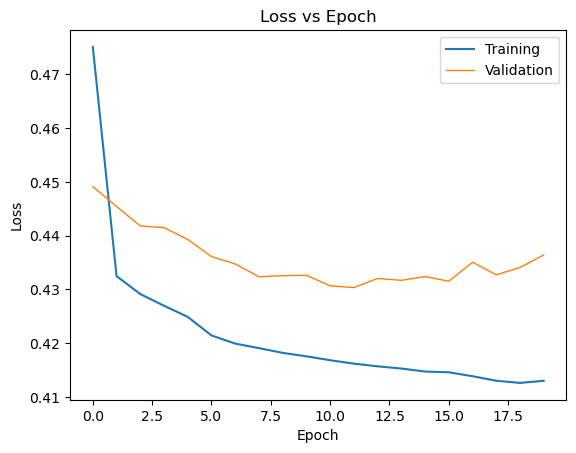

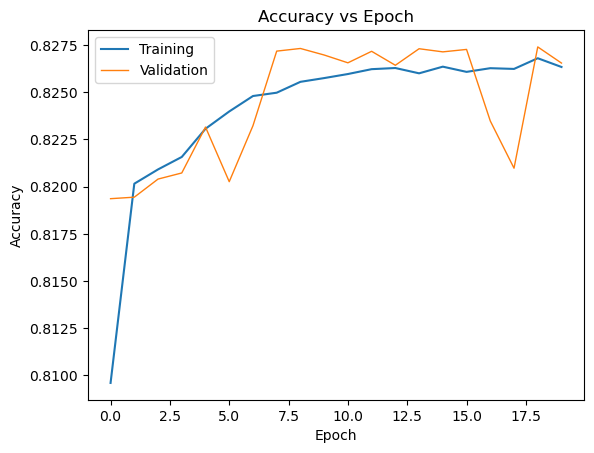

Final Accuracy: 82.74024521708961%


In [27]:
accuracy = train(model, train_loader, val_loader, lr = 0.001, epochs = 20, gamma = 1, create_plot = True, use_GPU = True, verbose = True)
print(f'Final Accuracy: {accuracy * 100}%')

### Hyperparameter tuning for Model 2

In [28]:
lr_params = [0.1, 0.01, 0.001]
batch_sizes = [32, 64, 128]
tuning_accs_deep = {}
for lr in lr_params:
    for batch_size in batch_sizes:
        train_loader, val_loader = loader(batch_size=batch_size)
        model = Net_deep()
        acc = train(model, train_loader, val_loader, lr = lr, epochs = 30, gamma = 0.995, create_plot = False, use_GPU = True, verbose = False)
        tuning_accs_deep[str(lr) + ', ' + str(batch_size)] = acc
        print(f'Training completed for Learning Rate: {lr}, Batch Size: {batch_size}')

tuning_accs_deep

Training completed for Learning Rate: 0.1, Batch Size: 32
Training completed for Learning Rate: 0.1, Batch Size: 64
Training completed for Learning Rate: 0.1, Batch Size: 128
Training completed for Learning Rate: 0.01, Batch Size: 32
Training completed for Learning Rate: 0.01, Batch Size: 64
Training completed for Learning Rate: 0.01, Batch Size: 128
Training completed for Learning Rate: 0.001, Batch Size: 32
Training completed for Learning Rate: 0.001, Batch Size: 64
Training completed for Learning Rate: 0.001, Batch Size: 128


{'0.1, 32': 0.707330375071271,
 '0.1, 64': 0.7034882100019826,
 '0.1, 128': 0.7806166326603665,
 '0.01, 32': 0.820067118669278,
 '0.01, 64': 0.8206005898096748,
 '0.01, 128': 0.8210181307273768,
 '0.001, 32': 0.8274537358387665,
 '0.001, 64': 0.8274961588025377,
 '0.001, 128': 0.8271864708619703}

Learning rate of 0.001 and batch size of 64 again provided the highest accuracy, 82.75% in this case

### Training model 2 on tuned hyperparamters and reporting accuracy on the test set

Using GPU NVIDIA GeForce GTX 1050...
Epoch 1 of 20: Train Loss = 0.4861871265368896 Validation Loss = 0.44366514085571174
Train Accuracy = 80.18 Validation Accuracy =82.03
Time taken on GPU: 17.178630590438843
Current epoch is best so far, Saving model...
Epoch 2 of 20: Train Loss = 0.4308247922122149 Validation Loss = 0.4401413353313644
Train Accuracy = 82.1 Validation Accuracy =82.07
Time taken on GPU: 15.009406089782715
Current epoch is best so far, Saving model...
Epoch 3 of 20: Train Loss = 0.4277229307805965 Validation Loss = 0.43838867593134184
Train Accuracy = 82.17 Validation Accuracy =82.06
Time taken on GPU: 14.272014141082764
Epoch 4 of 20: Train Loss = 0.4262486142307026 Validation Loss = 0.4393394004707177
Train Accuracy = 82.18 Validation Accuracy =81.45
Time taken on GPU: 14.969172954559326
Epoch 5 of 20: Train Loss = 0.4255616514516469 Validation Loss = 0.4405712013987383
Train Accuracy = 82.16 Validation Accuracy =82.08
Time taken on GPU: 17.57626461982727
Current epo

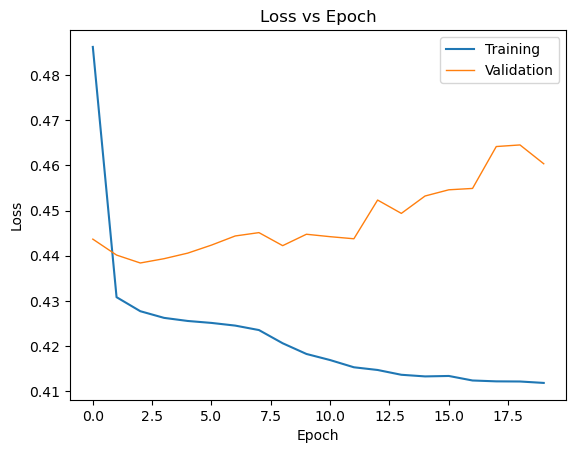

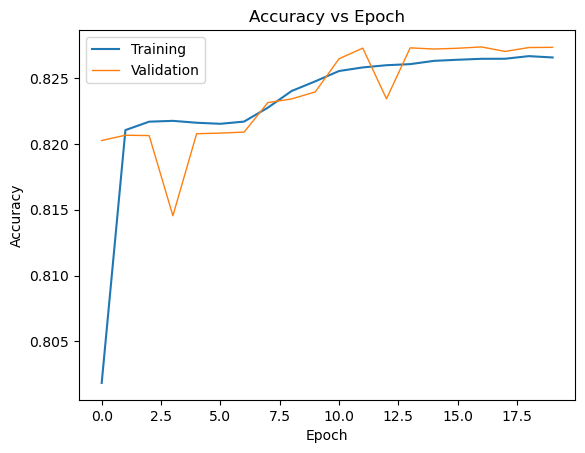

Accuracy on the Test set for tuned model 2: 82.73668281621728%


In [41]:
train_loader, val_loader = loader(batch_size = 64)
model_tuned = Net_deep()
acc = train(model_tuned, train_loader, val_loader, lr = 0.001, epochs = 20, gamma = 0.995, create_plot = True, use_GPU = True, verbose = True)
print(f'Accuracy on the Test set for tuned model 2: {acc * 100}%')